In [118]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from pathlib import Path
import os 
import sys 
import pandas as pd
sys.path.append("C:/Users/cwinklm/Documents/AggroUQ")

from torchvision import datasets, transforms
from PIL import Image

%load_ext autoreload
%autoreload 2

import seaborn as sns
from src.methods import AggregationMethods as am
from src.strategylist import StrategyList
from src.summary import AggregationSummary
from src.uncertainty_maps import UncertaintyMap
from src.datasets import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Notes

- we need uncertainty per class so that we compare how methods pick up on image-level manipulaions

In [119]:
data_path = Path("C:/Users/cwinklm/Documents/Data/v1-0-variations_NOISY/variations")
uq_path = Path("C:/Users/cwinklm/Documents/Data/uncertainty_arctique_v1-0-corrected_14/UQ_maps")
all_uq = os.listdir(uq_path)

In [136]:
task = "instance"
model_noise = 0
variation = "blood_cells"
data_noise = "0_00"
uq_method = "softmax"
decomp = "PU"

map_type = f"{task}_noise_{model_noise}_{variation}_{data_noise}_{uq_method}_{decomp}.npy"
uq_maps = np.load(uq_path.joinpath(map_type))

sample_idx_file = f"{task}_noise_{model_noise}_{variation}_{data_noise}_{uq_method}_{decomp}_sample_idx.npy"
sample_idx = np.load(str(uq_path).replace("UQ_maps", "UQ_metadata")+"/"+sample_idx_file)

mask_type = f"{variation}/{data_noise}/masks/{task}_noise_0"
image_type = f"{variation}/{data_noise}/images"

In [121]:
def get_image_mask_uq(uq_path, data_path, task, variation, data_noise, uq_method, decomp, uq_idx=None, sample_idx=None):

    map_type = f"{task}_noise_{model_noise}_{variation}_{data_noise}_{uq_method}_{decomp}.npy"
    uq_maps = np.load(uq_path.joinpath(map_type))

    sample_idx_file = f"{task}_noise_{model_noise}_{variation}_{data_noise}_{uq_method}_{decomp}_sample_idx.npy"
    sample_idxs = np.load(str(uq_path).replace("UQ_maps", "UQ_metadata")+"/"+sample_idx_file)

    mask_type = f"{variation}/{data_noise}/masks/{task}_noise_0"
    image_type = f"{variation}/{data_noise}/images" 

    if sample_idx is not None: 
        uq_idx = int(np.where(sample_idxs==sample_idx)[0][0])
    
    else: 
        if uq_idx is None: 
            uq_idx = np.random.randint(0, uq_maps.shape[0])
            sample_idx = sample_idxs[uq_idx]

    uq_map = uq_maps[uq_idx,:,:]

    image = np.array(Image.open(data_path.joinpath(image_type).joinpath(f"img_{sample_idx}.png")))
    mask = np.array(Image.open(data_path.joinpath(mask_type).joinpath(f"{sample_idx}.png")))

    return image, mask, uq_map, sample_idx

Text(0.5, 1.0, 'softmax')

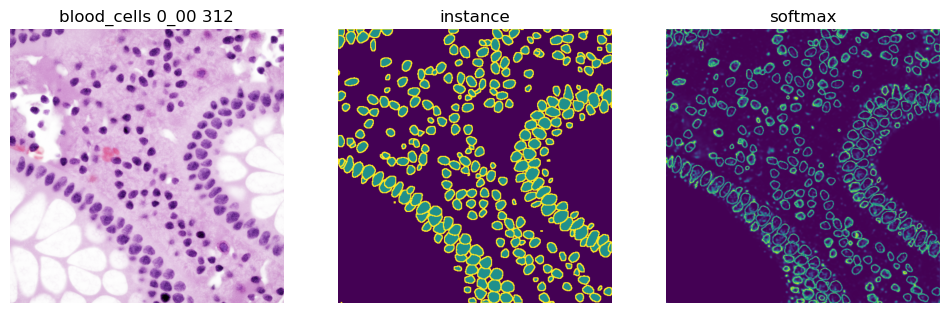

In [137]:
uq_idx = np.random.randint(0, uq_maps.shape[0])
uq_map = uq_maps[uq_idx,:,:]

image = np.array(Image.open(data_path.joinpath(image_type).joinpath(f"img_{sample_idx[uq_idx]}.png")))
mask = np.array(Image.open(data_path.joinpath(mask_type).joinpath(f"{sample_idx[uq_idx]}.png")))

plt.figure(figsize=(12,4))

plt.subplot(131)
plt.imshow(image)
plt.axis('off')
plt.title(f"{variation} {data_noise} {sample_idx[uq_idx]}")


plt.subplot(132)
plt.imshow(mask)
plt.axis('off')
plt.title(f"{task}")
#plt.colorbar() 


plt.subplot(133)
plt.imshow(uq_map)
plt.axis('off')
plt.title(f"{uq_method}")
#plt.colorbar()  

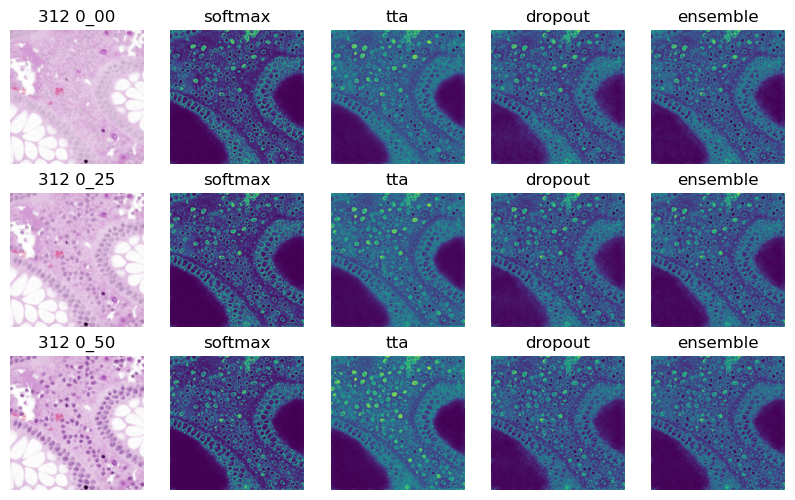

In [145]:
## Overview plot

task = "semantic"
model_noise = 0
variation = "nuclei_intensity"
#data_noise = "1_00"
#uq_method = "softmax"
decomp = "PU"

noise_levels = ["0_00", "0_25", "0_50"]  #["0_00", "0_50", "1_00"]
uq_methods = ["softmax", "tta", "dropout", "ensemble"]

plt.figure(figsize=(10,6))

for dn_idx, data_noise in enumerate(noise_levels): 

    for uq_idx, uq_method in enumerate(uq_methods): 

        img, mask, uq, si = get_image_mask_uq(uq_path, data_path, task, variation, 
                                              data_noise, uq_method, decomp, uq_idx=4, 
                                              sample_idx=312)
        #print(si)

        plt.subplot(len(noise_levels), len(uq_methods)+1, 1 + dn_idx*(len(uq_methods)+1))
        plt.imshow(img)
        plt.title(f"{si} {data_noise}")
        plt.axis("off")

        plt.subplot(len(noise_levels), len(uq_methods)+1, uq_idx + 2 + dn_idx*(len(uq_methods)+1))
        plt.imshow(uq)
        plt.title(uq_method)
        plt.axis("off")

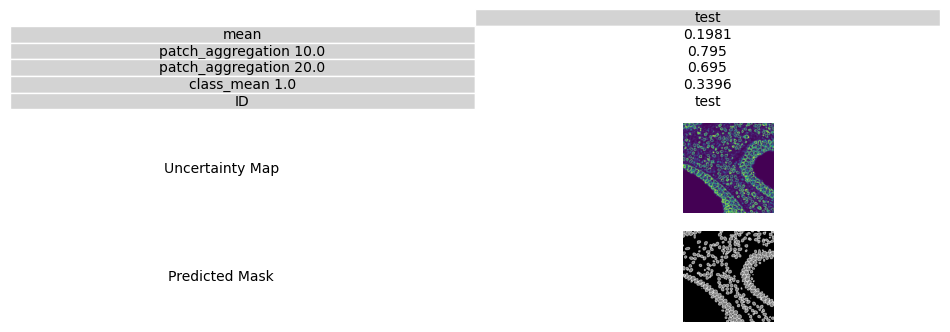

,Name,0
0,mean,0.19812
1,patch_aggregation 10.0,0.794883
2,patch_aggregation 20.0,0.695483
3,class_mean 1.0,0.3396
4,ID,test


In [135]:
img, mask, uq, si = get_image_mask_uq(uq_path, data_path, task, variation, 
                                              data_noise, uq_method, decomp, uq_idx=4, 
                                              sample_idx=312)


unc_maps = [UncertaintyMap(array=uq, mask=mask, name="test") ]

summary = AggregationSummary([(am.mean, None), 
                              (am.patch_aggregation, 10), 
                              (am.patch_aggregation, 20),
                              (am.class_mean, 1)
                              #(am.max, None), 
                              #(am.morans_I, None), 
                              #(am.gearys_C, None),
                              ])
# (B)
#summary = AggregationSummary(StrategyList.THRESHOLD)

results = summary.apply_methods(unc_maps, save_to_excel=False, do_plot=True)
results 

In [124]:
arrays = []
masks = []
names = []


for dn_idx, data_noise in enumerate(noise_levels): 

    for uq_idx, uq_method in enumerate(uq_methods): 

        img, mask, uq, si = get_image_mask_uq(uq_path, data_path, task, variation, 
                                              data_noise, uq_method, decomp, uq_idx=4, 
                                              sample_idx=312)

        arrays.append(uq/np.log(3))
        masks.append(mask)
        names.append(f"{data_noise}_{uq_method}_{si}")

# Define a list of uncertainty map instances.
# Those consist of a heatmap array, a mask (optional), and a name (optional).
unc_maps = [UncertaintyMap(array=array, mask=mask, name=name) for array, mask, name in zip(arrays, masks, names)]

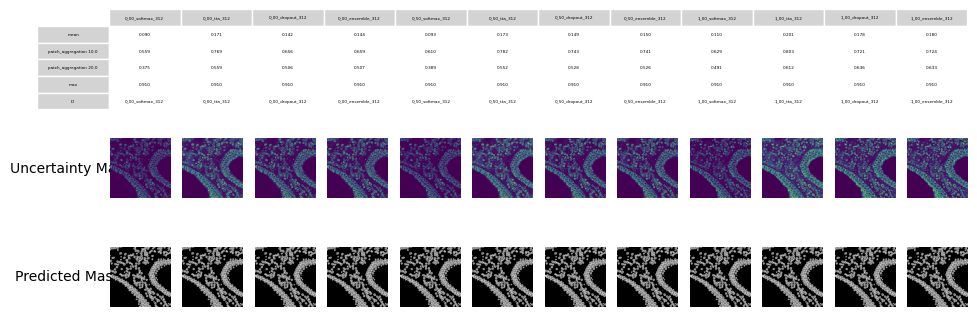

,Name,0,1,2,3,4,5,6,7,8,9,10,11
0,mean,0.089782,0.170582,0.142373,0.14365,0.093184,0.172957,0.148523,0.150356,0.110335,0.200843,0.17822,0.180289
1,patch_aggregation 10.0,0.559206,0.769185,0.65641,0.659481,0.609547,0.781828,0.743067,0.741283,0.628781,0.803148,0.721402,0.723534
2,patch_aggregation 20.0,0.374906,0.559209,0.506443,0.506807,0.389382,0.55211,0.527863,0.526295,0.491267,0.612488,0.63621,0.633056
3,max,0.910239,0.910239,0.910239,0.910239,0.910239,0.910239,0.910239,0.910239,0.910239,0.910239,0.910239,0.910239
4,ID,0_00_softmax_312,0_00_tta_312,0_00_dropout_312,0_00_ensemble_312,0_50_softmax_312,0_50_tta_312,0_50_dropout_312,0_50_ensemble_312,1_00_softmax_312,1_00_tta_312,1_00_dropout_312,1_00_ensemble_312


In [125]:
summary = AggregationSummary([(am.mean, None), 
                              (am.patch_aggregation, 10), 
                              (am.patch_aggregation, 20),
                              (am.max, None), 
                              #(am.morans_I, None), 
                              #(am.gearys_C, None),
                              ])
# (B)
#summary = AggregationSummary(StrategyList.THRESHOLD)

results = summary.apply_methods(unc_maps, save_to_excel=False, do_plot=True)
results 

In [126]:
results.melt()

,variable,value
0,Name,mean
1,Name,patch_aggregation 10.0
2,Name,patch_aggregation 20.0
3,Name,max
4,Name,ID
...,...,...
60,11,0.180289
61,11,0.723534
62,11,0.633056
63,11,0.910239


In [127]:
# DATA
N = 1
arrays = [uq_maps[i,:,:]/np.log(3) for i in range(N)]
masks = [None for index in range(N)]
names = [f"UncMap{index}" for index in range(N)]

# Define a list of uncertainty map instances.
# Those consist of a heatmap array, a mask (optional), and a name (optional).
unc_maps = [UncertaintyMap(array=array, mask=mask, name=name) for array, mask, name in zip(arrays, masks, names)]

In [128]:
# DATA
N = 1
arrays = [uq_maps[i,:,:]/np.log(6) for i in range(N)]
masks = [None for index in range(N)]
names = [f"UncMap{index}" for index in range(N)]

# Define a list of uncertainty map instances.
# Those consist of a heatmap array, a mask (optional), and a name (optional).
unc_maps = [UncertaintyMap(array=array, mask=mask, name=name) for array, mask, name in zip(arrays, masks, names)]

In [129]:
# SUMMARY
# Create summary object & choose aggregations you want to evaluate
# (A)
summary = AggregationSummary([(am.mean, None), 
                              (am.patch_aggregation, 10), 
                              (am.patch_aggregation, 20),
                              (am.max, None), 
                              #(am.morans_I, None), 
                              #(am.gearys_C, None),
                              ])
# (B)
#summary = AggregationSummary(StrategyList.THRESHOLD)

results = summary.apply_methods(unc_maps, save_to_excel=False, do_plot=False)
results # NOTE: Results are stored in a dataframe

,Name,0
0,mean,0.058486
1,patch_aggregation 10.0,0.376933
2,patch_aggregation 20.0,0.278752
3,max,0.558111
4,ID,UncMap0


ValueError: boxplot method requires numerical columns, nothing to plot.

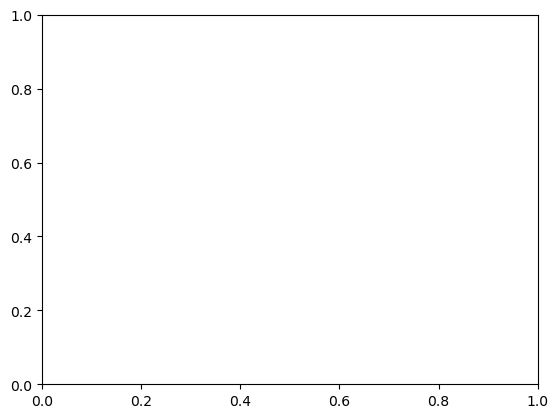

In [130]:
results.set_index("Name").T.boxplot(rot=90)


In [ ]:
task = "semantic"
model_noise = 0
variation = "blood_cells"
data_noise = "0_00"
uq_method = "tta"
decomp = "PU"

filename = "Arctique_aggregation_results.csv"


summary = AggregationSummary([(am.mean, None), 
                              (am.patch_aggregation, 10), 
                              (am.patch_aggregation, 20),
                              (am.max, None), 
                              #(am.morans_I, None), 
                              #(am.gearys_C, None),
                              ])

N = 10

for data_noise in ["0_00", "0_25", "0_50", "0_75", "1_00"]:

    map_type = f"{task}_noise_{model_noise}_{variation}_{data_noise}_{uq_method}_{decomp}.npy"
    uq_maps = np.load(data_path.joinpath(map_type))

    
    arrays = [uq_maps[i,:,:]/np.log(6) for i in range(N)]
    masks = [None for index in range(N)]
    names = [f"UncMap{index}" for index in range(N)]

    unc_maps = [UncertaintyMap(array=array, mask=mask, name=name) for array, mask, name in zip(arrays, masks, names)]

    results = summary.apply_methods(unc_maps, save_to_excel=False, do_plot=False)
    results = results.melt(id_vars=["Name"], var_name="Sample", value_name="Value")    
    results["DataNoise"] = data_noise

    if data_noise == "0_00":
        results.to_csv(filename, index=False)
    else:
        results.to_csv(filename, mode='a', header=False, index=False)
  



In [ ]:
all_res = pd.read_csv(filename)
all_res.head()

,Name,Sample,Value,DataNoise
0,mean,0,0.125785,0_00
1,patch_aggregation 10.0,0,0.437921,0_00
2,patch_aggregation 20.0,0,0.331092,0_00
3,max,0,0.558111,0_00
4,mean,1,0.123350,0_00


<Axes: xlabel='DataNoise', ylabel='Value'>

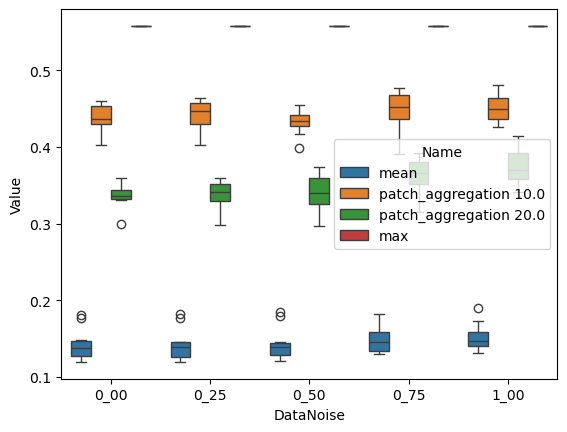

In [ ]:
sns.boxplot(x="DataNoise", y="Value", hue="Name", data=all_res)

In [ ]:
corr_res = all_res[all_res["DataNoise"]=="0_00"].pivot(columns="Name", values="Value", index="Sample")
corr_res

Name,max,mean,patch_aggregation 10.0,patch_aggregation 20.0
Sample,,,,
0,0.558111,0.125785,0.437921,0.331092
1,0.558111,0.123350,0.402480,0.299497
2,0.558111,0.131188,0.419940,0.332617
3,0.558111,0.140324,0.458324,0.342294
4,0.558111,0.148611,0.436182,0.331397
5,0.558111,0.119626,0.429873,0.359213
6,0.558111,0.177306,0.459648,0.344665
7,0.558111,0.135804,0.456559,0.338407
8,0.558111,0.141397,0.431596,0.334972


<Axes: xlabel='Name', ylabel='Name'>

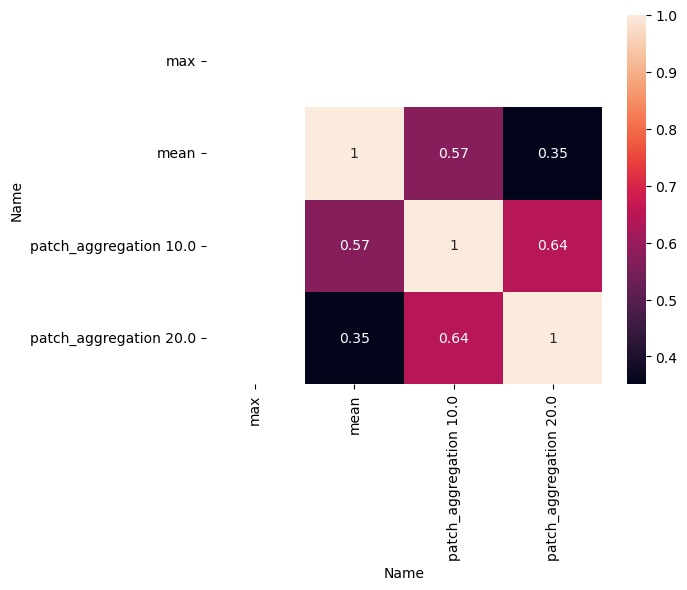

In [ ]:
#corr_res.corr()

sns.heatmap(corr_res.corr(), annot=True)